#### The code shows how a physics-informed neural network (PINN) can approximate the solution of a PDE.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import tensorflow as tf
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

Epoch 0, Loss: 48.04146194458008
Epoch 500, Loss: 0.04605776444077492
Epoch 1000, Loss: 0.004473191220313311
Epoch 1500, Loss: 0.0015675211325287819
Epoch 2000, Loss: 0.0009588368702679873
Epoch 2500, Loss: 0.0020567739848047495
Epoch 3000, Loss: 0.0005023885751143098
Epoch 3500, Loss: 0.0003755693032871932
Epoch 4000, Loss: 0.00030945223988965154
Epoch 4500, Loss: 0.00023930956376716495
Epoch 5000, Loss: 0.00020134270016569644
Epoch 5500, Loss: 0.0012781532714143395
Epoch 6000, Loss: 0.00013816611317452043
Epoch 6500, Loss: 0.00011774111771956086
Epoch 7000, Loss: 0.00010765837942017242
Epoch 7500, Loss: 0.00015606105444021523
Epoch 8000, Loss: 8.485042053507641e-05
Epoch 8500, Loss: 0.0006604419904761016
Epoch 9000, Loss: 0.00012343456910457462
Epoch 9500, Loss: 0.002685713581740856


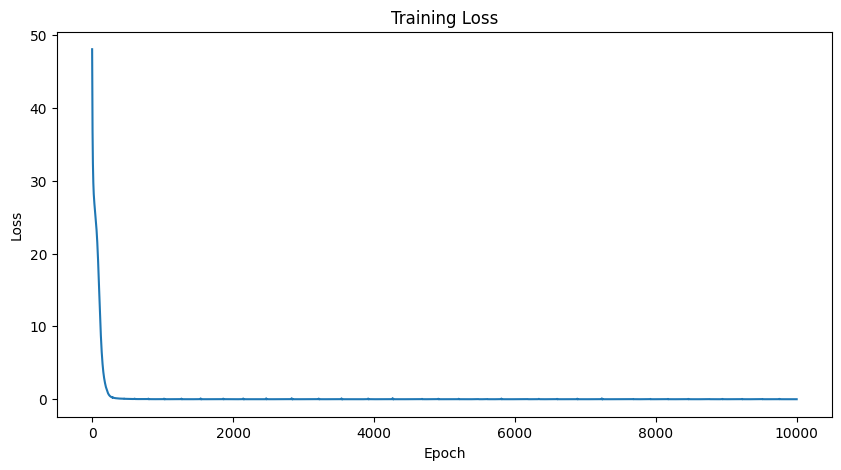

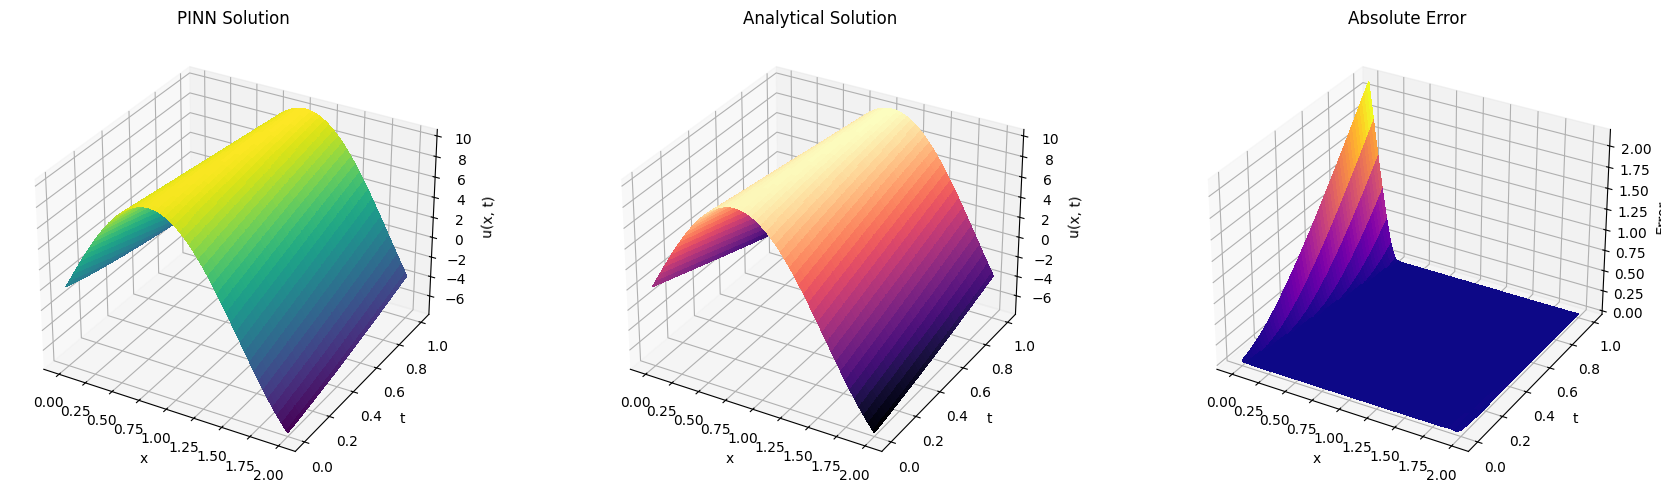

In [ ]:
class PINN(tf.keras.Model):
    def __init__(self, layers=[2, 50, 50, 50, 1]):
        super(PINN, self).__init__()
        self.network = tf.keras.Sequential()
        
        # Input layer
        self.network.add(tf.keras.layers.InputLayer(input_shape=(2,)))
        
        # Hidden layers with improved initialization
        for units in layers[1:-1]:
            self.network.add(tf.keras.layers.Dense(
                units, 
                activation='tanh',
                kernel_initializer='he_normal'
            ))
        
        # Output layer
        self.network.add(tf.keras.layers.Dense(layers[-1]))
    
    def call(self, inputs):
        return self.network(inputs)

def pde_residual(model, x, t):
    """
    Compute the residual of the PDE: du/dx = -4du/dt + 0.1u
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        X = tf.concat([x, t], axis=1)
        u = model(X)
        
        # Compute derivatives
        du_dx = tape.gradient(u, x)
        du_dt = tape.gradient(u, t)
    
    # PDE residual
    f = du_dx + 4 * du_dt - 0.1 * u
    
    return f

@tf.function
def loss_fn(model, x, t, x_boundary, u_boundary):
    """
    Compute the total loss function
    """
    # PDE loss
    x_interior = tf.concat([x, t], axis=1)
    pde_loss = tf.reduce_mean(tf.square(pde_residual(model, x, t)))
    
    # Boundary condition loss
    X_boundary = tf.concat([x_boundary, tf.zeros_like(x_boundary)], axis=1)
    u_pred = model(X_boundary)
    boundary_loss = tf.reduce_mean(tf.square(u_pred - u_boundary))
    
    # Combine losses
    total_loss = pde_loss + boundary_loss
    
    return total_loss

@tf.function
def train_step(model, optimizer, x, t, x_boundary, u_boundary):
    """
    Perform a single training step
    """
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x, t, x_boundary, u_boundary)
    
    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

def analytical_solution(x, t):
    """
    Analytical solution for the given PDE
    """
    return 10 * np.sin(2 * (x - t / 4)) * np.exp(0.025 * t)

def ode_solver(x, t):
    """
    ODE solver for comparison
    """
    def pde_system(t, u, x):
        """
        Define the ODE system based on the PDE
        """
        return [-4 * u[1] + 0.1 * u[0], u[1]]
    
    # Initial condition
    u0 = [10 * np.sin(2 * x), 0]
    
    # Solve the ODE
    solution = solve_ivp(
        pde_system, 
        [0, t], 
        u0, 
        args=(x,), 
        method='RK45'
    )
    
    return solution.y[0][-1]

def main():
    # Set random seed for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)

    # Hyperparameters
    N = 500  # Number of points
    epochs = 10000
    learning_rate = 0.001

    # Generate training data
    x = tf.random.uniform((N, 1), 0, 2, dtype=tf.float32)
    t = tf.random.uniform((N, 1), 0, 1, dtype=tf.float32)
    
    # Boundary conditions
    x_boundary = tf.linspace(0.0, 2.0, N)[:, None]
    u_boundary = 10 * tf.sin(2 * x_boundary)

    # Ensure type consistency
    x_boundary = tf.cast(x_boundary, tf.float32)
    u_boundary = tf.cast(u_boundary, tf.float32)

    # Initialize model and optimizer
    pinn = PINN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Training loop
    loss_history = []
    for epoch in range(epochs):
        loss = train_step(pinn, optimizer, x, t, x_boundary, u_boundary)
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")
        
        loss_history.append(loss.numpy())

    # Visualization and Analysis
    # Create grid for visualization
    x_range = np.linspace(0, 2, 100)
    t_range = np.linspace(0, 1, 50)
    X, T = np.meshgrid(x_range, t_range)

    # Prepare PINN predictions
    X_flat = np.column_stack([X.ravel(), T.ravel()])
    U_pinn = pinn(X_flat).numpy().reshape(X.shape)

    # Compute Analytical Solution
    U_analytical = analytical_solution(X, T)

    # Compute Numerical Solution
    U_numerical = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            U_numerical[i, j] = ode_solver(X[i, j], T[i, j])

    # Visualization
    # 1. Loss History
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # 2. Comparison of Solutions (3D Plot)
    fig = plt.figure(figsize=(18, 5))
    
    # PINN Solution
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, T, U_pinn, cmap=cm.viridis, linewidth=1, antialiased=False)
    ax1.set_title('PINN Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u(x, t)')

    # Analytical Solution
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, T, U_analytical, cmap=cm.magma, linewidth=1, antialiased=False)
    ax2.set_title('Analytical Solution')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('u(x, t)')

    # Error Surface
    ax3 = fig.add_subplot(133, projection='3d')
    error = np.abs(U_pinn - U_analytical)
    surf3 = ax3.plot_surface(X, T, error, cmap=cm.plasma, linewidth=1, antialiased=False)
    ax3.set_title('Absolute Error')
    ax3.set_xlabel('x')
    ax3.set_ylabel('t')
    ax3.set_zlabel('Error')

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()